# Setting for Colab

Edit->Notebook Setting->Enable GPU

In [1]:
dir_of_file='MyDrive/Colab Notebooks/attributionpriors/examples'

In [2]:
from google.colab import drive
import os

drive.mount('./gdrive')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('./gdrive/'+dir_of_file)

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Mounted at ./gdrive
Current working directory: /content
Current working directory: /content/gdrive/MyDrive/Colab Notebooks/attributionpriors/examples


In [3]:
import pkg_resources

if 'shap' not in [i.key for i in pkg_resources.working_set]:
  !pip install shap

# Import library

In [4]:
import sys
sys.path.insert(0, '../')

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt

import torch
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms

import shap

# Demo

In [6]:
class BinaryData(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X=X
        self.y=y
        self.transform=transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample=self.X[index,:]
        
        if self.transform is not None:
            sample=self.transform(sample)
        
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [7]:
batch_size=64

a_train=torch.empty(1000,1).uniform_(0,1)
x_train=torch.bernoulli(a_train)
x_train=torch.cat([x_train,x_train],axis=1)

y_train=x_train[:,0]

train_dataset=BinaryData(x_train, y_train)
train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
#a_test=torch.empty(1000,2).uniform_(0,1)
#x_test=torch.bernoulli(a_test)
#y_test=x_test[:,0]

#test_dataset=BinaryData(x_test, y_test)
#test_loader=DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(2,1),
                                      torch.nn.Sigmoid())
    def forward(self,x):
        x=self.layers(x)
        return x

In [10]:
def calculate_dependence(model):
    zero_arange=torch.tensor(np.concatenate([np.zeros(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)
    one_arange=torch.tensor(np.concatenate([np.ones(100).reshape(-1,1),
                                             np.arange(0,1,0.01).reshape(-1,1)],axis=1)).float().to(device)


    arange_zero=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.zeros(100).reshape(-1,1)],axis=1)).float().to(device)
    arange_one=torch.tensor(np.concatenate([np.arange(0,1,0.01).reshape(-1,1),
                                            np.ones(100).reshape(-1,1)],axis=1)).float().to(device)

    dep1=(model(one_arange)-model(zero_arange)).mean().detach().cpu().numpy().reshape(-1)[0]
    dep2=(model(arange_one)-model(arange_zero)).mean().detach().cpu().numpy().reshape(-1)[0]
    
    return dep2/dep1, dep1, dep2

In [21]:
device=torch.device('cuda')

convergence_list1_list_eg=[]
convergence_list2_list_eg=[]
convergence_list3_list_eg=[]

for k in [1,2,3,4,5]:

    print('k =',k)
    
    model=MLP().to(device)
    
    with torch.no_grad():
        model.layers[0].weight[0,0]=10
        model.layers[0].weight[0,1]=10
        model.layers[0].bias[0]=-6
        
    x_zeros = torch.ones_like(x_train[:,:])
    background_dataset = BinaryData(x_zeros)

    explainer = AttributionPriorExplainer(background_dataset, None, 64, k=k)        
        

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    bce_term = torch.nn.BCELoss()
    
    train_loss_list_mean_list=[]
    
    convergence_list1=[]
    convergence_list2=[]
    convergence_list3=[]
        
    for epoch in range(200):
        
        train_loss_list=[]
        
        for i, (x, y_true) in enumerate(train_loader):
            x, y_true= x.float().to(device), y_true.float().to(device)
            optimizer.zero_grad()
            
            y_pred=model(x)
            
            eg=explainer.attribution(model, x)
            eg_abs_mean=eg.abs().mean(0)
            
            loss=bce_term(y_pred, y_true.unsqueeze(1)) + eg_abs_mean[1]
            
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss_list.append(loss.item())
            
        train_loss_list_mean=np.mean(train_loss_list)
        
        train_loss_list_mean_list.append(train_loss_list_mean)
        convergence_list1.append(calculate_dependence(model)[0])
        convergence_list2.append(calculate_dependence(model)[1])
        convergence_list3.append(calculate_dependence(model)[2])
        
    convergence_list1_list_eg.append(convergence_list1)
    convergence_list2_list_eg.append(convergence_list2)
    convergence_list3_list_eg.append(convergence_list3)

k = 1
k = 2
k = 3
k = 4
k = 5


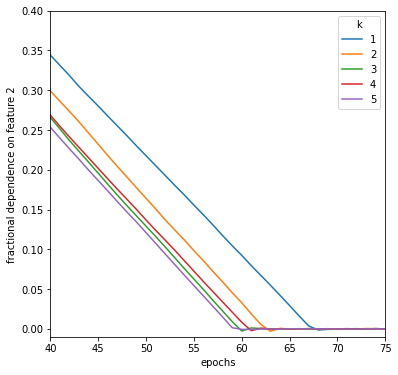

In [22]:
plt.figure(figsize=(6,6))

for k, convergence_list1 in enumerate(convergence_list1_list_eg):
    plt.plot((np.arange(len(convergence_list1))+1), convergence_list1,label=k+1)
    
plt.xlim([40,75])
plt.ylim([-0.01,0.4])
plt.legend(title='k')

plt.xlabel('epochs')
plt.ylabel('fractional dependence on feature 2')
plt.show()

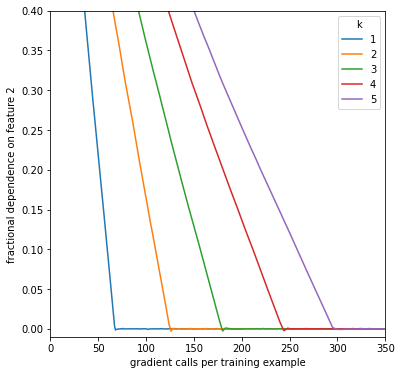

In [23]:
plt.figure(figsize=(6,6))

for k, convergence_list1 in enumerate(convergence_list1_list_eg):
    plt.plot((np.arange(len(convergence_list1))+1)*(k+1), convergence_list1,label=k+1)
    
plt.xlim([0,350])
plt.ylim([-0.01,0.4])
plt.legend(title='k')

plt.xlabel('gradient calls per training example')
plt.ylabel('fractional dependence on feature 2')
plt.show()

# example_usage

In [24]:
feature_mean=0
feature_sigma=1
dummy_sigma=0.5

n_samples=1000
n_features=3

X=np.random.randn(n_samples,n_features)*feature_sigma+feature_mean
X[:,2]=X[:,0]+np.random.randn(n_samples)*dummy_sigma

In [25]:
output_mean=0
output_sigma=0.5
Y=X[:,0]-X[:,1]+np.random.randn(n_samples)*output_sigma+output_mean
Y=Y.reshape([Y.shape[0],1])

In [26]:
data = pd.DataFrame({'Feature 0': X[:, 0], 'Feature 1': X[:, 1], 'Feature 2': X[:, 2], 'Outcome': Y.squeeze()})
alt.Chart(data).mark_point(filled=True).encode(
    x=alt.X(alt.repeat('column'), type='quantitative', scale=alt.Scale(domain=[-4, 4])),
    y=alt.Y('Outcome:Q', scale=alt.Scale(domain=[-6, 6]))
).properties(
    height=200,
    width=200
).repeat(
    column=['Feature 0', 'Feature 1', 'Feature 2']
).properties(
    title='The relationship between the outcome and the three features in our simulated data'
).configure_axis(
    labelFontSize=15,
    labelFontWeight=alt.FontWeight('lighter'),
    titleFontSize=15,
    titleFontWeight=alt.FontWeight('normal')
).configure_title(
    fontSize=18
)

alt.RepeatChart(...)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None):
        self.x=x
        self.y=y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):        
        if self.y is not None:
            return self.x[index], self.y[index]
        else:
            return self.x[index]

In [28]:
batch_size=20

dataset=CustomDataset(x=X,y=Y)
train_dataset, test_dataset, valid_dataset=random_split(dataset, [int(n_samples*0.8), int(n_samples*0.1), int(n_samples*0.1)])

train_dataloader=DataLoader(dataset=train_dataset, batch_size=20, shuffle=True, drop_last=True)
test_dataloader=DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)
valid_dataloader=DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), shuffle=True, drop_last=True)

In [29]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(2,1),
                                      torch.nn.Sigmoid())
    def forward(self,x):
        x=self.layers(x)
        return x

In [30]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel,self).__init__()
        self.layers=torch.nn.Sequential(torch.nn.Linear(n_features,5),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(5,1))
                                        
    def forward(self, x):
        return self.layers(x)

## train with an attribution prior

In [31]:
device=torch.device('cuda')
model=CustomModel().to(device)


explainer = AttributionPriorExplainer(train_dataset[:][0], None, batch_size=batch_size, k=1)
explainer_valid = AttributionPriorExplainer(valid_dataset[:][0], None, batch_size=100, k=1)

optimizer=torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0, dampening=0)

loss_func = torch.nn.MSELoss()

batch_count=0
valid_loss_list=[]
step_list=[]
for epoch in range(15):
    for i, (x, y_true) in enumerate(train_dataloader):
        batch_count+=1

        x, y_true= x.float().to(device), y_true.float().to(device)
        optimizer.zero_grad()

        y_pred=model(x)
        
        eg=explainer.attribution(model, x)
        
        loss=loss_func(y_pred, y_true) + 30*(eg*eg)[:,2].mean()

        loss.backward()
        optimizer.step()
        
        if batch_count%10==0:
            valid_loss=[]
            for i, (x, y_true) in enumerate(valid_dataloader):

                x, y_true= x.float().to(device), y_true.float().to(device)

                y_pred = model(x)
                loss=loss_func(y_pred, y_true)
                valid_loss.append(loss.item())

                eg=explainer_valid.attribution(model,x)

                #print(eg.abs().mean(axis=0).detach().cpu())

            valid_loss_list.append(np.mean(valid_loss))
            step_list.append(batch_count)

                    
test_loss=[]                    
for i, (x, y_true) in enumerate(test_dataloader):

    x, y_true= x.float().to(device), y_true.float().to(device)

    y_pred = model(x)
    loss=loss_func(y_pred, y_true)
    test_loss.append(loss.item())
    
print('MSE:',np.mean(test_loss))

MSE: 0.29290977120399475


In [32]:
data = pd.DataFrame({
    'Iteration': step_list,
    'Validation Loss': valid_loss_list
})
alt.Chart(data
).mark_line().encode(alt.X('Iteration:Q'), alt.Y('Validation Loss:Q', scale=alt.Scale(domain=[0.0, 2.5])))



alt.Chart(...)

### using shap.GradientExplainer

In [33]:
explainer=shap.GradientExplainer(model=model, data=torch.Tensor(X).to(device))
shap_values=explainer.shap_values(torch.Tensor(X).to(device), nsamples=200)

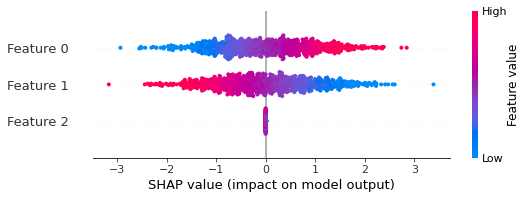

In [34]:
shap.summary_plot(shap_values, X)

### using implemented explainer

In [36]:
explainer_temp = AttributionPriorExplainer(dataset, input_index=0, batch_size=5, k=200)

temp_dataloader=DataLoader(dataset=dataset, batch_size=5, shuffle=True, drop_last=True)

eg_list=[]
x_list=[]
for i, (x, y_true) in enumerate(temp_dataloader):
    x, y_true= x.float().to(device), y_true.float().to(device)

    eg_temp=explainer_temp.attribution(model, x)
    eg_list.append(eg_temp.detach().cpu().numpy())
    x_list.append(x.detach().cpu().numpy())
eg_list_concat=np.concatenate(eg_list)
x_list_concat=np.concatenate(x_list)    

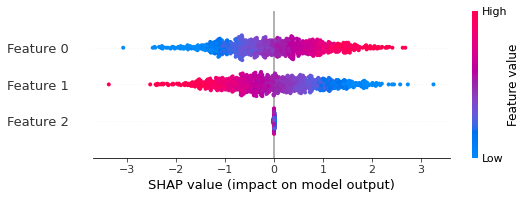

In [37]:
shap.summary_plot(eg_list_concat, x_list_concat)

## train without an attribution prior

In [40]:
device=torch.device('cuda')
model=CustomModel().to(device)


explainer = AttributionPriorExplainer(train_dataset, input_index=0, batch_size=batch_size, k=1)
explainer_valid = AttributionPriorExplainer(valid_dataset, input_index=0, batch_size=100, k=1)

optimizer=torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0, dampening=0)

loss_func = torch.nn.MSELoss()

batch_count=0
valid_loss_list=[]
step_list=[]
for epoch in range(15):
    for i, (x, y_true) in enumerate(train_dataloader):
        batch_count+=1

        x, y_true= x.float().to(device), y_true.float().to(device)
        optimizer.zero_grad()

        y_pred=model(x)
        
        eg=explainer.attribution(model, x)
        
        loss=loss_func(y_pred, y_true)# + 30*(eg*eg)[:,2].mean()

        loss.backward()
        optimizer.step()
        
        if batch_count%10==0:
            valid_loss=[]
            for i, (x, y_true) in enumerate(valid_dataloader):

                x, y_true= x.float().to(device), y_true.float().to(device)

                y_pred = model(x)
                loss=loss_func(y_pred, y_true)
                valid_loss.append(loss.item())

                eg=explainer_valid.attribution(model,x)

                #print(eg.abs().mean(axis=0).detach().cpu())

            valid_loss_list.append(np.mean(valid_loss))
            step_list.append(batch_count)

                    
test_loss=[]                    
for i, (x, y_true) in enumerate(test_dataloader):

    x, y_true= x.float().to(device), y_true.float().to(device)

    y_pred = model(x)
    loss=loss_func(y_pred, y_true)
    test_loss.append(loss.item())
    
print('MSE:',np.mean(test_loss))

MSE: 0.28107723593711853


In [41]:
data = pd.DataFrame({
    'Iteration': step_list,
    'Validation Loss': valid_loss_list
})
alt.Chart(data
).mark_line().encode(alt.X('Iteration:Q'), alt.Y('Validation Loss:Q', scale=alt.Scale(domain=[0.0, 2.5])))



alt.Chart(...)

### using shap.GradientExplainer

In [42]:
explainer=shap.GradientExplainer(model=model, data=torch.Tensor(X).to(device))
shap_values=explainer.shap_values(torch.Tensor(X).to(device), nsamples=200)

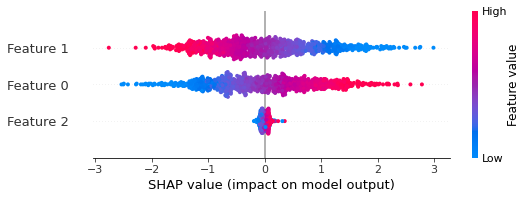

In [43]:
shap.summary_plot(shap_values, X)

### using implemented explainer

In [44]:
explainer_temp = AttributionPriorExplainer(dataset, input_index=0, batch_size=5, k=200)

temp_dataloader=DataLoader(dataset=dataset, batch_size=5, shuffle=True, drop_last=True)

eg_list=[]
x_list=[]
for i, (x, y_true) in enumerate(temp_dataloader):
    x, y_true= x.float().to(device), y_true.float().to(device)

    eg_temp=explainer_temp.attribution(model, x)
    eg_list.append(eg_temp.detach().cpu().numpy())
    x_list.append(x.detach().cpu().numpy())
eg_list_concat=np.concatenate(eg_list)
x_list_concat=np.concatenate(x_list)    

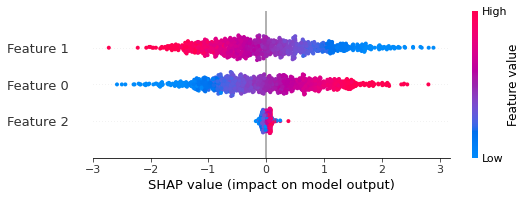

In [45]:
shap.summary_plot(eg_list_concat, x_list_concat)

# MNIST

## download dataset

In [46]:
batch_size=50
num_epochs=60

valid_size=5000

In [47]:
train_dataset=torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.RandomRotation([-15,15], fill = (0,)),
                                                                                                            transforms.RandomAffine(degrees=0, translate=(4/28,4/28), fillcolor=0),
                                                                                                            transforms.ToTensor(),
                                                                                                            transforms.Normalize(mean=(0.5,), std=(1,)),
                                                                                                            ]))
train_dataset=Subset(train_dataset,range(valid_size,len(train_dataset)))

valid_dataset=torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                            transforms.Normalize(mean=(0.5,), std=(1,)),
                                                                                                            ]))
valid_dataset=Subset(valid_dataset,range(valid_size))

test_dataset=torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                            transforms.Normalize(mean=(0.5,), std=(1,)),
                                                                                                            ]))

Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead


In [48]:
train_dataloader=DataLoader(train_dataset, shuffle=True, drop_last=True, batch_size=batch_size)
valid_dataloader=DataLoader(valid_dataset, shuffle=False, drop_last=True, batch_size=batch_size)
test_dataloader=DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=batch_size)

In [49]:
class MNISTModel(torch.nn.Module):
    def __init__(self):
        super(MNISTModel,self).__init__()
        
        
        layer1_conv=torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=int((5-1)/2));torch.nn.init.xavier_uniform_(layer1_conv.weight);torch.nn.init.zeros_(layer1_conv.bias);    
        layer1_batchnorm=torch.nn.BatchNorm2d(num_features=32, momentum=0.1)
        layer1_activation=torch.nn.ReLU()
        layer1_maxpool=torch.nn.MaxPool2d(kernel_size=2, padding=0)
        
        layer2_conv=torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=int((5-1)/2));torch.nn.init.xavier_uniform_(layer2_conv.weight);torch.nn.init.zeros_(layer2_conv.bias);    
        layer2_batchnorm=torch.nn.BatchNorm2d(num_features=64, momentum=0.1)
        layer2_activation=torch.nn.ReLU()
        layer2_maxpool=torch.nn.MaxPool2d(kernel_size=2, padding=0)        
        
        layer3_flatten=torch.nn.Flatten()
        layer3_fc=torch.nn.Linear(3136,1024);torch.nn.init.xavier_uniform_(layer3_fc.weight);torch.nn.init.zeros_(layer3_fc.bias);
        layer3_activation=torch.nn.ReLU()
        layer3_dropout=torch.nn.Dropout(p=0.5)
        
        layer4_fc=torch.nn.Linear(1024, 10)
        
        
        self.layers=torch.nn.Sequential(layer1_conv, layer1_batchnorm, layer1_activation, layer1_maxpool,
                                        layer2_conv, layer2_batchnorm, layer2_activation, layer2_maxpool,
                                        layer3_flatten, layer3_fc, layer3_activation, layer3_dropout,
                                        layer4_fc)
        #print(dir(self.layers))
        #print(self.layers._get_name())
        
    def forward(self,x):
        x=self.layers(x)
        return x
    


In [50]:
device=torch.device('cuda')
model=MNISTModel().to(device)

In [51]:
len(train_dataset)

55000

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
#scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)

In [127]:
"""
global_step=0
"""
lamb=0.5

explainer=AttributionPriorExplainer(reference_dataset=train_dataset, input_index=0, batch_size=batch_size, k=5)

loss_func=torch.nn.CrossEntropyLoss()

for epoch in range(60):
    for i, (images, labels_true) in enumerate(train_dataloader):
        images, labels_true = images.to(device), labels_true.to(device) 

        optimizer.zero_grad()
        
        
        labels_onehot_pred=model(images)
        labels_onehot_true=torch.nn.functional.one_hot(labels_true, num_classes=10)
        eg=explainer.attribution(model, images, valid_output=labels_onehot_true)

        eg_standardized=(eg-eg.mean(dim=(-1,-2,-3), keepdim=True))/\
        (eg.std(dim=(-1,-2,-3),keepdim=True).clamp(max=1/np.sqrt(torch.numel(eg[0]))))

        loss=loss_func(labels_onehot_pred, labels_true)

        loss.backward(retain_graph=True)

        optimizer.step()
        
        """
        global_step+=1
        if (global_step*50)%60000==0:
            pass
        """
    scheduler.step()
    break
        
        
    

In [121]:
images.shape, labels_true.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [113]:
eg_standardized=(eg-eg.mean(dim=(-1,-2,-3), keepdim=True))/\
(eg.std(dim=(-1,-2,-3),keepdim=True).clamp(max=1/np.sqrt(torch.numel(eg[0]))))

In [122]:
images.shape

torch.Size([50, 1, 28, 28])

In [126]:
torch.nn.functional.one_hot??

In [111]:
eg_standardized[0].std()

tensor(1., device='cuda:0', grad_fn=<StdBackward>)

In [101]:
eg[0].mean()

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)

In [102]:
eg[0].std()

tensor(0.0241, device='cuda:0', grad_fn=<StdBackward>)

In [86]:
np.sqrt()

3.1622776601683795

# AttributionPriorExplainer

In [14]:
"""
https://github.com/suinleelab/attributionpriors/blob/master/attributionpriors/pytorch_ops.py
https://github.com/slundberg/shap/blob/master/shap/explainers/_gradient.py

Currently, in the case of one-hot encoded class output, ignore attribution for output indices that are not true.

"""

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

class AttributionPriorExplainer():
    def __init__(self, reference_dataset, input_index, batch_size, k):
        self.reference_dataloader=DataLoader(dataset=reference_dataset,
                                             batch_size=batch_size*k,
                                             shuffle=True,
                                             drop_last=True)
        self.reference_dataloader_iterator=iter(self.reference_dataloader)
        
        self.batch_size=batch_size
        self.k=k
        self.input_index=input_index
        
    def get_reference_data(self):
        try:
            reference_data=next(self.reference_dataloader_iterator)
        except:
            self.reference_dataloader_iterator=iter(self.reference_dataloader)
            reference_data=next(self.reference_dataloader_iterator)
        if self.input_index is None:
          return reference_data
        else:
          return reference_data[self.input_index]
    
    def interpolate_input_reference(self, input_data, reference_data):
        
        alpha=torch.empty(self.batch_size, self.k).uniform_(0,1).to(input_data.device)
        alpha=alpha.view(*([self.batch_size, self.k,]+[1]*len(input_data.shape[1:])))
        
        input_reference_interpolated=(1-alpha)*reference_data+(alpha)*input_data.unsqueeze(1)
        
        return input_reference_interpolated
        
    def diff_input_reference(self, input_data, reference_data):
        return input_data.unsqueeze(1)-reference_data

    def get_grad(self, model, input_reference_interpolated, valid_output):
        input_reference_interpolated.requires_grad=True
        
        input_reference_interpolated_grad=torch.zeros(input_reference_interpolated.shape).float().to(input_reference_interpolated.device)
        for i in range(self.k):
            batch_input=input_reference_interpolated[:,i,]
            batch_output=model(batch_input)
            
            if valid_output is None:
              grad_out=grad(outputs=batch_output,
                            inputs=batch_input,
                            grad_outputs=torch.ones_like(batch_output).to(input_reference_interpolated.device),
                            create_graph=True)[0]    
            else:
              grad_out=grad(outputs=batch_output,
                            inputs=batch_input,
                            grad_outputs=valid_output,
                            create_graph=True)[0]                         
            
            input_reference_interpolated_grad[:,i,]=grad_out
        
        return input_reference_interpolated_grad
        
    def attribution(self, model, input_data, valid_output=None):
        model_dtype=next(model.parameters()).dtype
        reference_data=self.get_reference_data().to(model_dtype).to(input_data.device)
        
        assert input_data.dtype==model_dtype
        assert input_data.shape[0]==self.batch_size
        assert input_data.shape[1:]==reference_data.shape[1:]
        assert input_data.device==next(model.parameters()).device
        
        reference_data=reference_data.view(self.batch_size, self.k, *reference_data.shape[1:])
        
        input_reference_interpolated=self.interpolate_input_reference(input_data, reference_data)
        input_reference_diff=self.diff_input_reference(input_data, reference_data)
        
        input_reference_interpolated_grad=self.get_grad(model, input_reference_interpolated, valid_output)
        diff_interpolated_grad=input_reference_diff*input_reference_interpolated_grad
        expected_grad=diff_interpolated_grad.mean(axis=1)
    
        return expected_grad


"""
if list(batch_output.shape[1:])==[1]:
  # scalar output

else:
  # vector output
  if grad_output is None:
    grad_out=grad(outputs=batch_output,
                  inputs=batch_input,
                  grad_outputs=torch.ones_like(batch_output).to(input_reference_interpolated.device),
                  create_graph=True)[0]                  
  else:
    grad_out=grad(outputs=batch_output,
                  inputs=batch_input,
                  grad_outputs=grad_outputs.to(input_reference_interpolated.device),
                  create_graph=True)[0]  

def gather_nd(self,params, indices):
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i]*m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

sample_indices=torch.arange(0,batch_output.size(0)).to(input_reference_interpolated.device)
indices_tensor=torch.cat([sample_indices.unsqueeze(1),
                          sparse_output.unsqueeze(1).to(input_reference_interpolated.device)],dim=1)              
batch_output=self.gather_nd(batch_output, indices_tensor)
grad_out=grad(outputs=batch_output,
              inputs=batch_input,
              grad_outputs=torch.ones_like(batch_output).to(input_reference_interpolated.device),
              create_graph=True)[0] 
print('a',torch.ones_like(batch_output).to(input_reference_interpolated.device).shape)
print('equal',np.all((grad_out==grad_out2).cpu().numpy()))
"""    

In [ ]:
optimizer1.param_groups[0]['amsgrad']

False

In [ ]:
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer2, gamma=0.95)
#scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)

In [ ]:
optimizer2.param_groups[0]['params'][-1]

Parameter containing:
tensor([-0.0015,  0.0211,  0.0202, -0.0191, -0.0076,  0.0261,  0.0183,  0.0278,
        -0.0307, -0.0147], device='cuda:0', requires_grad=True)

In [ ]:
len(optimizer1.param_groups)

NameError: ignored

In [ ]:
scheduler1.get_last_lr()

[9.5e-05]

In [ ]:
scheduler1.step()

In [ ]:
optimizer1.param_groups[0]['initial_lr']

0.0001

In [ ]:
optimizer1.param_groups[0]['lr']

9.025e-05

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1,))
           )

In [ ]:
device=torch.device('cuda')

convergence_list1_list_eg=[]
convergence_list2_list_eg=[]
convergence_list3_list_eg=[]

for k in [1,2,3,4,5]:

    print('k =',k)
    
    model=MLP().to(device)
    
    with torch.no_grad():
        model.layers[0].weight[0,0]=10
        model.layers[0].weight[0,1]=10
        model.layers[0].bias[0]=-6
        
    x_zeros = torch.ones_like(x_train[:,:])
    background_dataset = BinaryData(x_zeros)

    explainer = AttributionPriorExplainer(background_dataset, 64, k=k)        
        

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    bce_term = torch.nn.BCELoss()
    
    train_loss_list_mean_list=[]
    
    convergence_list1=[]
    convergence_list2=[]
    convergence_list3=[]
        
    for epoch in range(200):
        
        train_loss_list=[]
        
        for i, (x, y_true) in enumerate(train_loader):
            x, y_true= x.float().to(device), y_true.float().to(device)
            optimizer.zero_grad()
            
            y_pred=model(x)
            
            eg=explainer.attribution(model, x)
            eg_abs_mean=eg.abs().mean(0)
            
            loss=bce_term(y_pred, y_true.unsqueeze(1)) + eg_abs_mean[1]
            
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss_list.append(loss.item())
            
        train_loss_list_mean=np.mean(train_loss_list)
        
        train_loss_list_mean_list.append(train_loss_list_mean)
        convergence_list1.append(calculate_dependence(model)[0])
        convergence_list2.append(calculate_dependence(model)[1])
        convergence_list3.append(calculate_dependence(model)[2])
        
    convergence_list1_list_eg.append(convergence_list1)
    convergence_list2_list_eg.append(convergence_list2)
    convergence_list3_list_eg.append(convergence_list3)

In [ ]:
model(img),model(img).shape

(tensor([[ 1.7051e-01, -9.0027e-01,  2.6485e-01,  1.3276e-01,  6.8088e-01,
           2.0468e-01, -8.0064e-01,  1.8387e-01,  1.1786e+00,  4.3168e-01],
         [ 4.9254e-01,  1.9631e-01,  1.5949e-01,  1.0267e+00,  6.4631e-03,
           5.1652e-01,  5.7739e-01,  1.1331e+00, -8.5396e-02, -1.7443e-01],
         [-5.7186e-01,  7.6871e-01, -3.6368e-01,  2.0005e-01,  3.9858e-01,
           4.4502e-01, -4.5243e-02,  3.9672e-01,  1.6317e+00,  5.1657e-01],
         [ 6.1337e-01, -2.5391e-01, -1.7952e-01, -8.8335e-02, -8.0266e-01,
          -8.2843e-01, -1.5498e-01,  1.1513e+00, -2.6314e-01,  1.3754e-02],
         [ 9.9703e-01,  8.4184e-01, -2.5169e-01,  2.1888e-01,  1.5385e-01,
          -1.6915e-01,  1.9417e-01,  4.9207e-01,  1.3116e-01,  3.8430e-01],
         [ 3.2576e-01,  5.1697e-01, -5.6247e-01, -7.2443e-01, -7.0746e-01,
           1.1664e+00, -1.0313e+00,  4.8841e-01,  1.4285e+00, -5.7030e-02],
         [ 1.8233e-01, -9.9167e-02, -7.5018e-01, -3.1680e-01, -3.9804e-01,
           2.1690e-

In [ ]:
model(img).shape

torch.Size([50, 10])

In [ ]:
img.shape

torch.Size([10, 1, 28, 28])

In [ ]:
train_dataloader=DataLoader(dataset=train_dataset, batch_size=10)
for img,label in train_dataloader:
    print(img)
    break

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

In [ ]:
torch.nn.MaxPool2d(kernel_size=2, padding='valid')

MaxPool2d(kernel_size=2, stride=2, padding=valid, dilation=1, ceil_mode=False)

In [ ]:
torch.nn.MaxPool2d(kernel_size=2)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
    
train_dataloader=DataLoader(dataset=train_dataset, batch_size=10)
loss_func=torch.nn.CrossEntropyLoss()

for images, labels_true in train_dataloader:
    images=images
    labels_pred=model.forward(images)
    print(labels_pred.shape)
    
    loss_func(labels_pred, labels_true)
    
    

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten()
  (5): Linear(in_features=1024, out_features=1024, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=1024, out_features=10, bias=True)
)


NameError: name 'train_dataset' is not defined

In [ ]:
import tensorflow as tf

In [ ]:
image = tf.constant(np.arange(1, 24+1, dtype=np.int32), shape=[2,2, 2, 3])

In [ ]:
new_image = tf.image.per_image_standardization(image)

In [ ]:
np.var(new_image[0])

1.0

In [ ]:
new_image

<tf.Tensor: shape=(2, 2, 2, 3), dtype=float32, numpy=
array([[[[-1.593255  , -1.3035723 , -1.0138896 ],
         [-0.7242068 , -0.4345241 , -0.14484136]],

        [[ 0.14484136,  0.4345241 ,  0.7242068 ],
         [ 1.0138896 ,  1.3035723 ,  1.593255  ]]],


       [[[-1.593255  , -1.3035723 , -1.0138896 ],
         [-0.7242068 , -0.4345241 , -0.14484136]],

        [[ 0.14484136,  0.4345241 ,  0.7242068 ],
         [ 1.0138896 ,  1.3035723 ,  1.593255  ]]]], dtype=float32)>

In [ ]:
np.var(new_image)

1.0

In [ ]:
torch.nn.Dropout?

In [ ]:
import torch

In [ ]:
torch.nn.Conv2d??

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
    
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [ ]:
model = Net()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset1,batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [ ]:
device=torch.device('cuda')
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    break

In [ ]:
data.shape

torch.Size([64, 1, 28, 28])

In [ ]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

# AttributionPriorExplainer

In [ ]:
"""

https://github.com/suinleelab/attributionpriors/blob/master/attributionpriors/pytorch_ops.py
https://github.com/slundberg/shap/blob/master/shap/explainers/_gradient.py

"""

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

class AttributionPriorExplainer():
    def __init__(self, reference_dataset, batch_size, k):
        self.reference_dataloader=DataLoader(dataset=reference_dataset,
                                             batch_size=batch_size*k,
                                             shuffle=True,
                                             drop_last=True)
        self.reference_dataloader_iterator=iter(self.reference_dataloader)
        
        self.batch_size=batch_size
        self.k=k
        
    def get_reference_data(self):
        try:
            reference_data=next(self.reference_dataloader_iterator)
        except:
            self.reference_dataloader_iterator=iter(self.reference_dataloader)
            reference_data=next(self.reference_dataloader_iterator)
        
        return reference_data
    
    def interpolate_input_reference(self, input_data, reference_data):
        
        alpha=torch.empty(self.batch_size, self.k).uniform_(0,1).to(input_data.device)
        alpha=alpha.view(*([self.batch_size, self.k,]+[1]*len(input_data.shape[1:])))
        
        input_reference_interpolated=(1-alpha)*reference_data+(alpha)*input_data.unsqueeze(1)
        
        return input_reference_interpolated
        
    def diff_input_reference(self, input_data, reference_data):
        return input_data.unsqueeze(1)-reference_data
    
    def get_grad(self, model, input_reference_interpolated):
        input_reference_interpolated.requires_grad=True
        
        input_reference_interpolated_grad=torch.zeros(input_reference_interpolated.shape).float().to(input_reference_interpolated.device)
        for i in range(self.k):
            batch_input=input_reference_interpolated[:,i,]
            batch_output=model(batch_input)
            
            
            grad_out=grad(outputs=batch_output,
                     inputs=batch_input,
                     grad_outputs=torch.ones_like(batch_output).to(input_reference_interpolated.device),
                     create_graph=True)[0]
            input_reference_interpolated_grad[:,i,]=grad_out
        
        return input_reference_interpolated_grad
        
    def attribution(self, model, input_data):
        model_dtype=next(model.parameters()).dtype
        reference_data=self.get_reference_data().to(model_dtype).to(input_data.device)
        
        assert input_data.dtype==model_dtype
        assert input_data.shape[0]==self.batch_size
        assert input_data.shape[1:]==reference_data.shape[1:]
        assert input_data.device==next(model.parameters()).device
        
        reference_data=reference_data.view(self.batch_size, self.k, *reference_data.shape[1:])
        
        input_reference_interpolated=self.interpolate_input_reference(input_data, reference_data)
        input_reference_diff=self.diff_input_reference(input_data, reference_data)
        
        input_reference_interpolated_grad=self.get_grad(model, input_reference_interpolated)
        
        diff_interpolated_grad=input_reference_diff*input_reference_interpolated_grad
        expected_grad=diff_interpolated_grad.mean(axis=1)
    
        return expected_grad

In [ ]:
ㅠ